In [3]:
import os
import spacy
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import matplotlib.pyplot as plt


# cargar modelo de lenguaje de spacy para español
nlp = spacy.load("es_core_news_sm")

# cargar archivos de discurso
discursos = []
data_dir = "../data/mananeras/"  # ruta relativa a la carpeta "src" hacia la carpeta "data"
for filename in ["1erinforme.txt", "2doinforme.txt", "3erinforme.txt", "4toinforme.txt"]:
    with open(data_dir + filename, "r", encoding="utf-8") as f:
        discursos.append(f.read())

In [4]:
len(discursos)

4

## Lemmatization and Tokenization

In [5]:
from nltk.stem import WordNetLemmatizer

# definir el lematizador para español
lemmatizer = WordNetLemmatizer()

# tokenizar y normalizar el texto
stop_words = set(stopwords.words('spanish'))

# agregar palabras específicas
stop_words.update(['mil', 'millones', 'año', '2'])

tokens_list = []
for discurso in discursos:
    doc = nlp(discurso)
    tokens = []
    for token in doc:
        if not token.is_punct and not token.is_stop:
            lemma = lemmatizer.lemmatize(token.text.lower(), pos='v')
            if lemma not in stop_words and not all(c.isspace() for c in lemma):
                tokens.append(lemma)
    tokens_list.append(tokens)

As a result we have two lists, one list where all the tokens of the 4 speeches have been merged and another "token_list" containing 4 lists of tokens, each one representing each speech.

In [6]:
print(len(tokens))
print(len(tokens_list))
tokens[:10]

1842
4


['amigas',
 'amigos',
 'servidores',
 'públicos',
 'pueblo',
 'méxico',
 'decidimos',
 'informar',
 'sitio',
 'lugar']

## Frequency Analysis

In [7]:
from nltk import FreqDist

# Calculando la frecuencia de las palabras
fdist = FreqDist(tokens)

# Imprimiendo las 10 palabras más comunes
print(fdist.most_common(20))

[('ciento', 29), ('méxico', 20), ('pesos', 17), ('gobierno', 14), ('país', 10), ('pueblo', 9), ('pandemia', 9), ('pobres', 9), ('bienestar', 8), ('mundo', 8), ('construcción', 8), ('crecimiento', 7), ('ingreso', 7), ('logrado', 7), ('inversión', 7), ('atención', 7), ('públicos', 6), ('nacional', 6), ('población', 6), ('general', 6)]


## Visualization with Altair

In [16]:
import altair as alt

# Obtener las 10 palabras más comunes
top_words = dict(fdist.most_common(20))

# Convertir las claves a una lista y crear un dataframe
df = pd.DataFrame({'Palabras': list(top_words.keys()), 'Frecuencia': list(top_words.values())})

# Crear la figura usando Altair
chart = alt.Chart(df).mark_bar(color='green').encode(
    x=alt.X('Frecuencia:Q', axis=alt.Axis(title='Frequencies', labelFontSize=14)),
    y=alt.Y('Palabras:N', sort='-x', axis=alt.Axis(title='Words', labelFontSize=14)),
    tooltip=['Palabras', 'Frecuencia']
).properties(
    title={
        'text': ['Most common words in speeches'],
        'fontSize': 16,
        'fontWeight': 'bold',
        'anchor': 'middle',
        'color': 'black'
    },
    width=600,
    height=400
)

# Mostrar la figura con la cuadrícula habilitada
chart.configure_axis(labelFontSize=12, grid=True).configure_title(fontSize=16, color='black')

alt.Chart(...)

#### The use of the word "ciento" is very interesting, since it implies that on multiple occasions the president makes references to percentages, that is, to proportions. This is one way in which the recipients of the speech can get a clearer idea of the proportions that he uses.

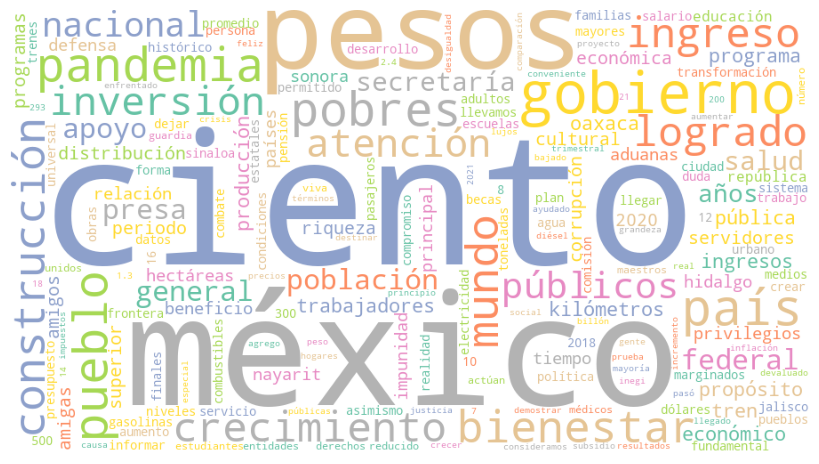

In [9]:
import random

# importando las paletas de colores
from palettable.colorbrewer.qualitative import Set2_8

# creando una lista de colores a partir de la paleta Set2
color_list = [tuple(rgb) for rgb in Set2_8.colors]

# Generando una wordcloud con la nueva paleta de colores
wordcloud = WordCloud(width=900, height=500, background_color='white', stopwords=stopwords,
                      min_font_size=10, colormap='Set2', color_func=lambda *args, **kwargs: color_list[random.randint(0, 7)]).generate_from_frequencies(fdist)

# Mostrando la imagen
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

## Sentiment Analysis

In [10]:
from textblob import TextBlob

sentimientos = []
for tokens in tokens_list:
    discurso = " ".join(tokens)
    blob = TextBlob(discurso)
    polaridad = blob.sentiment.polarity
    subjetividad = blob.sentiment.subjectivity
    sentimientos.append({"polaridad": polaridad, "subjetividad": subjetividad})

In [17]:
for i, sentimiento in enumerate(sentimientos):
    print(f"Speech {i+1}: Polarity={sentimiento['polaridad']}, Subjectivity={sentimiento['subjetividad']}")

Speech 1: Polarity=0.1257407407407407, Subjectivity=0.3725396825396825
Speech 2: Polarity=-0.025555555555555557, Subjectivity=0.43888888888888894
Speech 3: Polarity=2.312964634635743e-17, Subjectivity=0.39999999999999997
Speech 4: Polarity=0.10208333333333333, Subjectivity=0.35751488095238093


#### The results show the polarity and subjectivity of sentiment for each of the four speeches analyzed. Polarity is measured on a scale of -1 to 1, while subjectivity is a number indicating when the speech is based on the speaker's personal opinion rather than on objective facts.

#### As can be seen, the subjectivity scores of the 4 speeches are between 0.35 and 0.44. This suggests that the speaker, President Andrés Manuel López Obrador, expresses to a greater extent his personal opinion of the facts rather than objective reality.

## Identification of Main Topics

In [18]:
from gensim import corpora, models
import numpy as np
# Crear una lista de diccionarios, donde cada diccionario representa un discurso
dict_list = []
for i, tokens in enumerate(tokens_list):
    dict_list.append({"id": i, "texto": ' '.join(tokens)})
    
# Crear un diccionario de términos a partir de los discursos
dictionary = corpora.Dictionary([doc["texto"].split() for doc in dict_list])

# Crear un corpus (lista de bolsas de palabras) a partir del diccionario
corpus = [dictionary.doc2bow(doc["texto"].split()) for doc in dict_list]

# Crear un modelo LDA con 5 tópicos
lda_model = models.ldamodel.LdaModel(corpus=corpus,
                                     id2word=dictionary,
                                     num_topics=5,
                                     passes=10,
                                     alpha='auto')

# Imprimir los tópicos más importantes para cada discurso
for doc in dict_list:
    bow = dictionary.doc2bow(doc["texto"].split())
    topics = lda_model[bow]
    top_topics = sorted(topics, key=lambda x: x[1], reverse=True)[:3]
    print(f"Speech {doc['id'] + 1}: {', '.join([f'Topic {topic[0]+1} ({round(topic[1]*100, 2)}%)' for topic in top_topics])}")

Speech 1: Topic 5 (99.95%)
Speech 2: Topic 2 (99.9%)
Speech 3: Topic 3 (99.94%)
Speech 4: Topic 3 (99.91%)


In [13]:
type(lda_model.show_topic(0))

list

In [14]:
# Define las listas
topic1 = lda_model.show_topic(0)
topic2 = lda_model.show_topic(1)
topic3 = lda_model.show_topic(2)
topic4 = lda_model.show_topic(3)

# Convierte cada lista en un dataframe de pandas
df_t1 = pd.DataFrame(topic1, columns=['token', 'score'])
df_t2 = pd.DataFrame(topic2, columns=['token', 'score'])
df_t3 = pd.DataFrame(topic3, columns=['token', 'score'])
df_t4 = pd.DataFrame(topic4, columns=['token', 'score'])

# Crea la visualización con Altair para cada dataframe
chart_t1 = alt.Chart(df_t1).mark_bar().encode(
    x='score',
    y="token"
).properties(title="Topic 1", width=400, height=300)

chart_t2 = alt.Chart(df_t2).mark_bar().encode(
    x='score',
    y="token"
).properties(title="Topic 2", width=400, height=300)

chart_t3 = alt.Chart(df_t3).mark_bar().encode(
    x='score',
    y="token"
).properties(title="Topic 3", width=400, height=300)

chart_t4 = alt.Chart(df_t4).mark_bar().encode(
    x='score',
    y="token"
).properties(title="Topic 4", width=400, height=300)

# Muestra las visualizaciones
chart_t1 | chart_t2

alt.HConcatChart(...)

In [15]:
chart_t3 | chart_t4

alt.HConcatChart(...)